In [1]:
# Plot gdp per capita and cultural_index per capita on the same graph for every region
# to show how the cultural index can completer the gdp per capita index

In [2]:
import sys

sys.path.append("../")

import pandas as pd
import numpy as np

from dotenv import load_dotenv

load_dotenv()
import os

import sqlite3

NEW_DB_PATH = os.getenv("NEW_DB_PATH")
DATA_ENV_PATH = os.getenv("DATA_ENV_PATH")

conn = sqlite3.connect(NEW_DB_PATH)

In [3]:
# Load GDP DATA

In [4]:
def get_population(data_path_environment):
    pop_region = pd.read_csv(
        data_path_environment
        + "/ENS - Cultural Index - Countries Databases - population_region.csv"
    )
    pop_value = pd.read_csv(
        data_path_environment
        + "/ENS - Cultural Index - Countries Databases - population_value.csv"
    )
    df_population = pd.merge(pop_region, pop_value, on="region_code_atlas")

    df_population = df_population[~df_population["value"].isna()]
    df_population["value"] = df_population["value"].apply(lambda x: x.replace(",", "."))
    df_population["value"] = df_population["value"].astype(float)
    df_population["year"] = df_population["year"].astype(int)
    df_population = df_population.drop_duplicates()

    df_equiv = (
        df_population[["region_code", "region_code_atlas"]]
        .drop_duplicates()
        .reset_index(drop=True)
    )

    df_population = df_population.drop("region_code", axis=1)
    df_population = df_population.drop_duplicates().reset_index(drop=True)

    # in case there is two different values for the same region_code_atlas/year by mistakes, things could add up
    df_population = df_population.drop_duplicates(
        ["region_code_atlas", "year"], keep="first"
    )
    df_population = df_population.dropna().reset_index(drop=True)

    # create a new DataFrame with year values for every 10 years
    # new_years = list(range(min(df_population['year']), max(df_population['year'])+1, 10))

    full_list = []
    for region_code in list(set(df_population["region_code_atlas"])):
        df_population_filtered = df_population[
            df_population["region_code_atlas"] == region_code
        ]

        # create a new DataFrame with year values for every 10 years
        new_years = list(
            range(
                min(df_population_filtered["year"]),
                max(df_population_filtered["year"]) + 1,
                10,
            )
        )

        new_df = pd.DataFrame({"year": new_years})
        new_df["region_code_atlas"] = region_code

        new_df = pd.merge(
            new_df,
            df_population_filtered,
            on=["year", "region_code_atlas"],
            how="outer",
        )
        new_df = new_df.sort_values("year")
        new_df["value"] = new_df["value"].interpolate(method="linear")
        new_df = new_df.dropna().reset_index(drop=True)

        full_list.append(new_df)

    df_years = pd.concat([x for x in full_list])
    df_years = df_years.reset_index(drop=True)

    final = pd.merge(df_equiv, df_years, on="region_code_atlas")
    final = final.groupby(["region_code", "year"])["value"].sum().reset_index()
    df_years = final.rename(columns={"value": "population"})

    return df_years



def get_maddison_data(data_path_environment):
    # country_code_maddison #year #gdp_per_capita
    df_maddison = pd.read_csv(
        data_path_environment + "/gdp_per_capita_maddison.csv", index_col=[0]
    )

    # region_code #code_country_maddison #code_country
    gdp_equiv = pd.read_csv(
        data_path_environment
        + "/ENS - Cultural Index - Countries Databases - gdp_consolidate_table.csv"
    )
   
    gdp_equiv = gdp_equiv[["region_code", "code_country_maddison"]]
    gdp_equiv.columns = ["region_code", "country_code_maddison"]
    gdp_equiv = gdp_equiv.dropna().reset_index(drop=True)

    df_maddison_stats = pd.merge(gdp_equiv, df_maddison, on="country_code_maddison")

    return df_maddison_stats

In [5]:
data_gdp = get_maddison_data(DATA_ENV_PATH)
data_gdp =data_gdp[data_gdp['year']<=1880]
data_gdp.to_sql('gdp', conn, if_exists = 'replace', index=False)
data_gdp.to_csv('../environnement_data/gdp.csv')

In [6]:
df_population = get_population(DATA_ENV_PATH)
# get the smooth of the population
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [7]:
list_population_smoothed = []
for region  in df_population['region_code'].unique():
    df_loess = df_population[df_population['region_code']==region]
    df_loess =df_loess.sort_values(by='year')
    # Fit a LOESS regression
    population_smooth = lowess(df_loess['population'], df_loess['year'], frac=0.2)
    smoothed_df = pd.DataFrame(population_smooth, columns=['year', 'population'])
    smoothed_df['region_code'] = region
    list_population_smoothed.append(smoothed_df)

df_population_smoothed = pd.concat([x for x in list_population_smoothed])

<Axes: xlabel='year'>

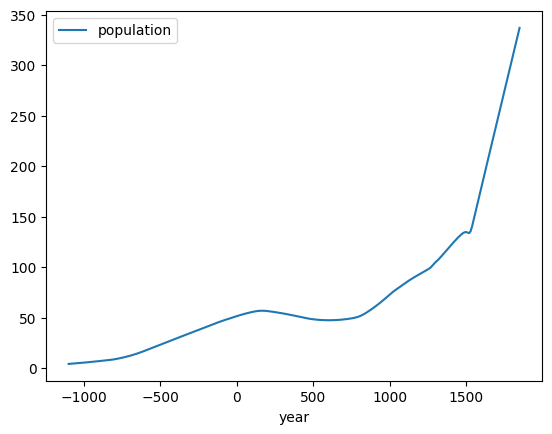

In [8]:
df_region = pd.read_csv('../environnement_data/region_code_region_name.csv')
df_population_smoothed_clean_region = pd.merge(df_population_smoothed, df_region, on = 'region_code')
df_population_smoothed_clean_region[df_population_smoothed_clean_region['region_code']=='re_chinese_world'].plot(x="year", y = 'population')

In [9]:

df_population_smoothed_clean_region.to_csv('../environnement_data/population_region_name.csv')
df_population_smoothed.to_sql('population', conn, if_exists = 'replace', index=False)
df_population_smoothed.to_csv('../environnement_data/population.csv')


### Insert Clean GDP

In [10]:
df_gdp_clean = data_gdp[data_gdp['year']>=1810]
count_points = df_gdp_clean.region_code.value_counts()
count_points = count_points[count_points>10]

df_gdp_clean = df_gdp_clean[df_gdp_clean['region_code'].isin(list(count_points.index))]

regions = ['re_eastern_europe',
 're_france',
 're_italy',
 're_low_countries',
 're_nordic_countries',
 're_united_kingdom']

df_gdp_clean = df_gdp_clean[df_gdp_clean['region_code'].isin(regions)]
df_gdp_clean = df_gdp_clean.reset_index(drop=True)

In [11]:
df_gdp_clean.to_sql('gdp_clean', conn, if_exists = 'replace', index=False)
df_gdp_clean.to_csv('../environnement_data/gdp_clean.csv')